In [2]:
import numpy as np
import pandas as pd
from pandas import datetime
import random
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# prophet by Facebook
from fbprophet import Prophet
train = pd.read_csv("train.csv", parse_dates = True, low_memory = False, index_col = 'Date')
store = pd.read_csv("store.csv", low_memory = False)
test= pd.read_csv("test.csv", parse_dates = True, low_memory = False, index_col = 'Date')

In [14]:
print(train.shape)
train.head(5)

(1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [15]:
print(test.shape)
test.head(5)

(41088, 7)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [16]:
print(store.shape)
store.head(5)

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [17]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

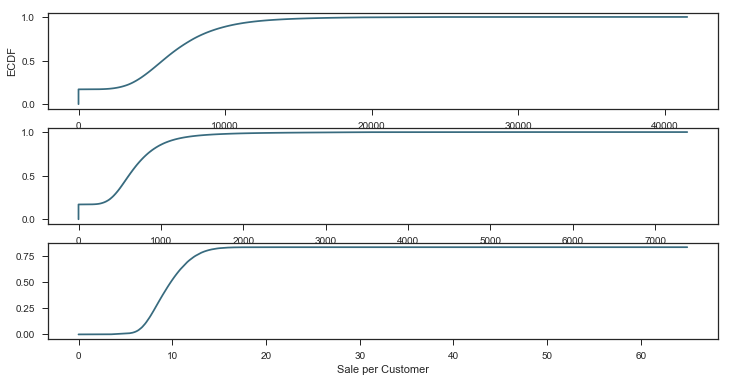

In [18]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [19]:
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
store['CompetitionDistance'].fillna(100000, inplace = True)
random.seed(20)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(random.randint(2002,2012))
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(random.randint(1,12))
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(0)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)
store.fillna(0, inplace = True)
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

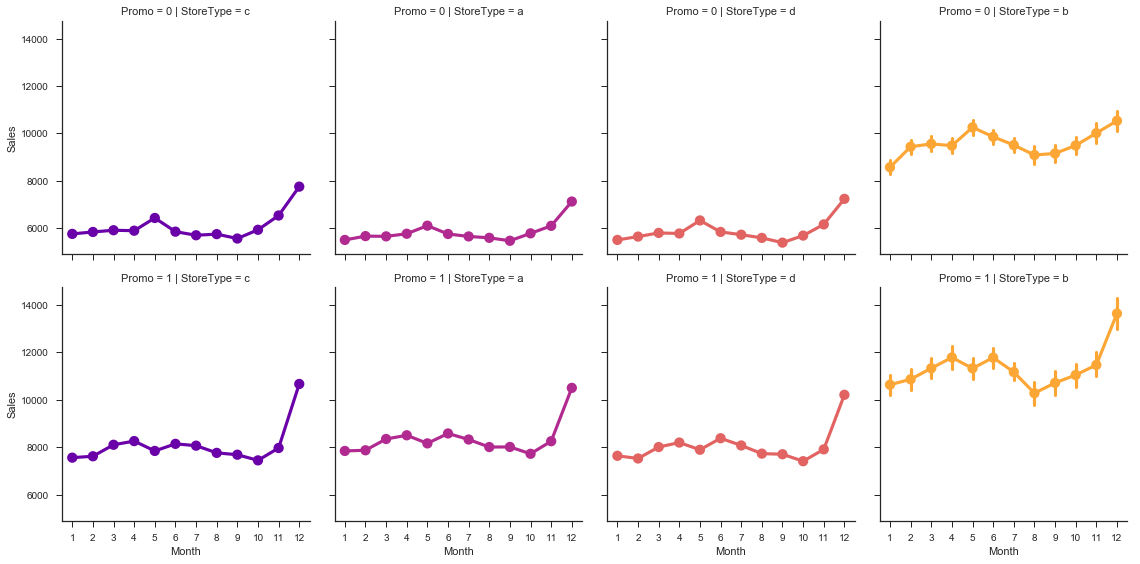

In [20]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

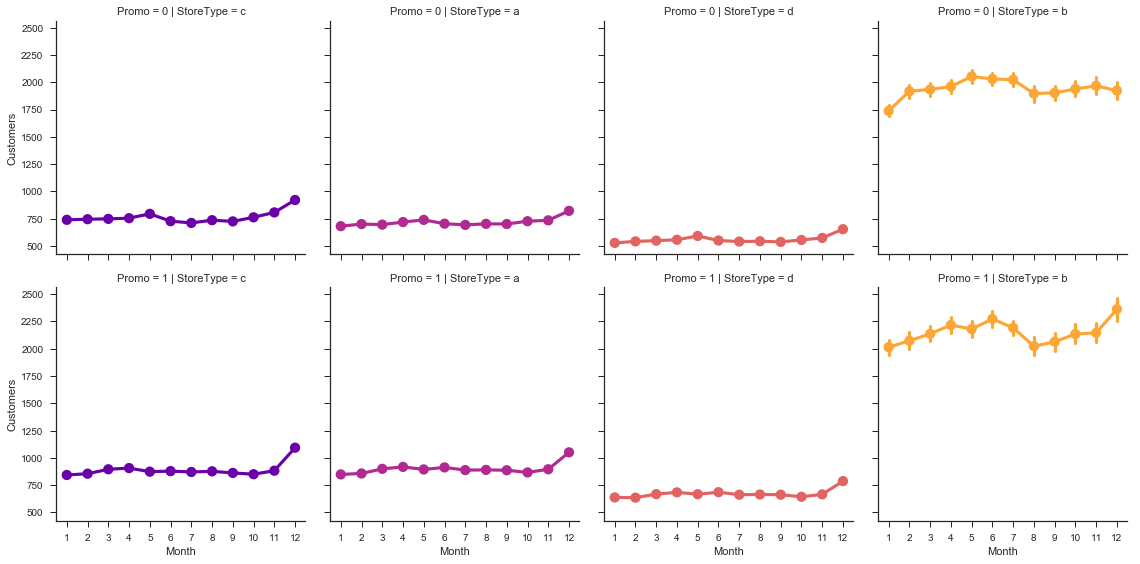

In [21]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

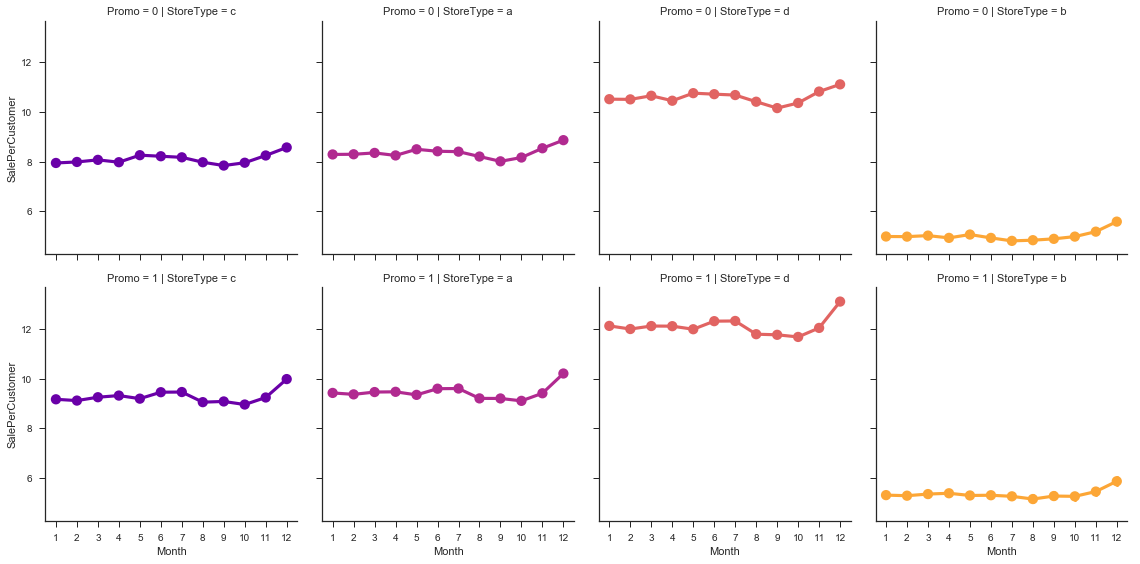

In [22]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

Plotted Frequency of Sales Values (for Open Stores)


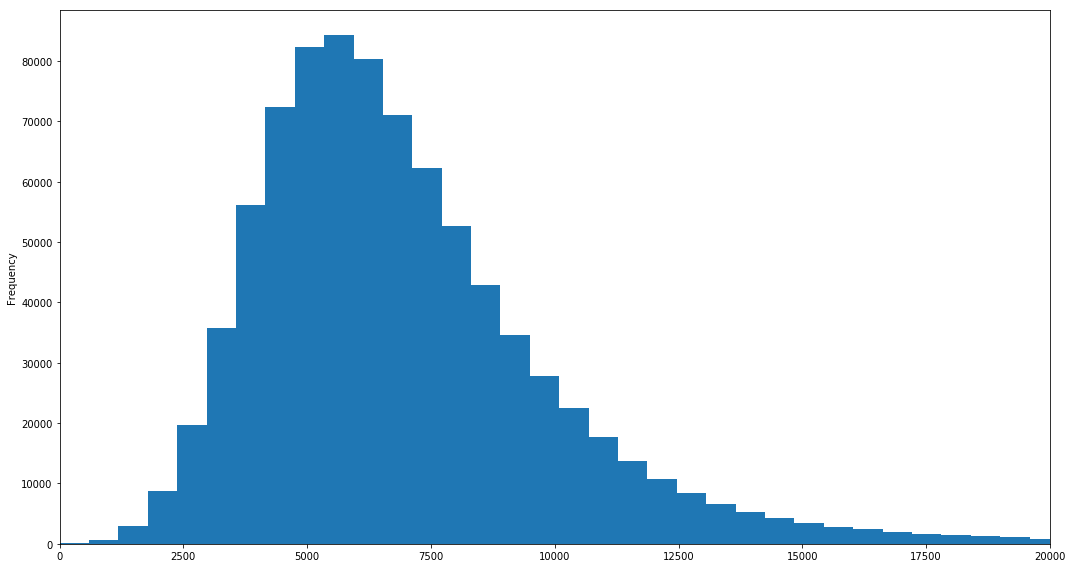

In [15]:
#开门的店面的Sales分布图
fig, (axis1) = plt.subplots(1, 1, figsize=(15, 8))
train_open= train[train["Open"] != 0]
train_open["Sales"].plot(kind="hist", bins=70, xlim=(0, 20000), ax=axis1)
fig.tight_layout()
print("Plotted Frequency of Sales Values (for Open Stores)")

Plotted Frequency of Sales Values (for Open Stores)


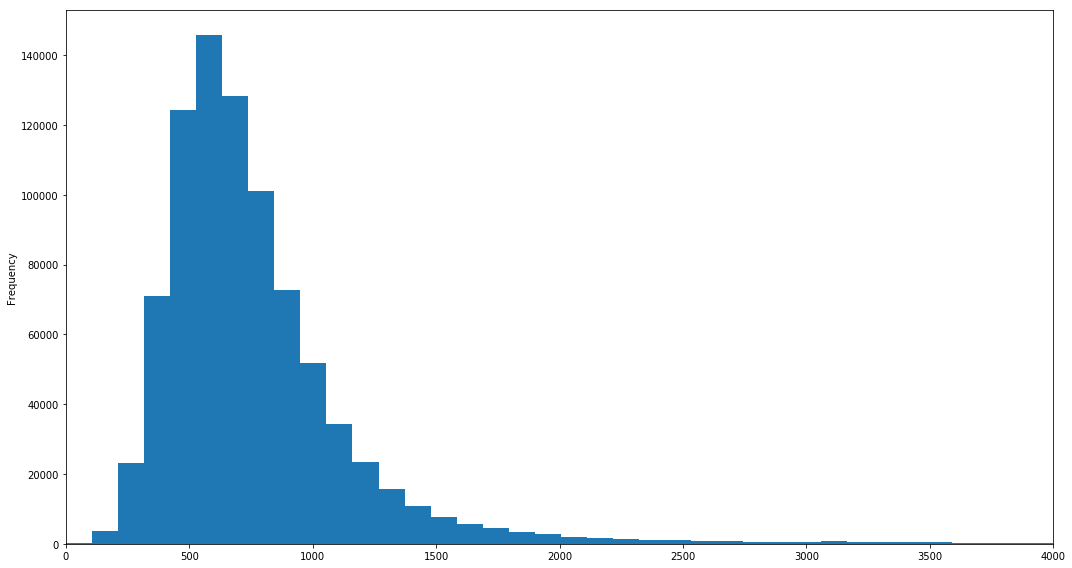

In [18]:
#开门的店面的Customers分布图
fig, (axis1) = plt.subplots(1, 1, figsize=(15, 8))
train_open= train[train["Open"] != 0]
train_open["Customers"].plot(kind="hist", bins=70, xlim=(0, 4000), ax=axis1)
fig.tight_layout()
print("Plotted Frequency of Sales Values (for Open Stores)")

Plotted Frequency of Sales Values (for Open Stores)


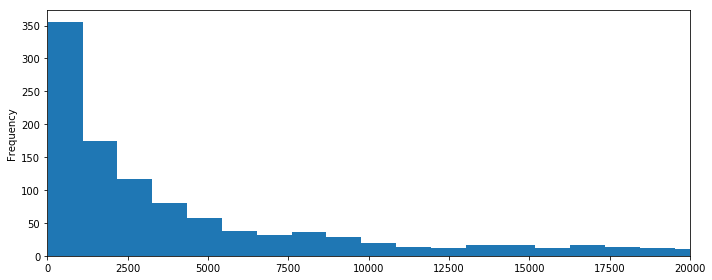

In [21]:
#开门的店面的CompetitionDistance分布图
fig, (axis1) = plt.subplots(1, 1, figsize=(10, 4))
store["CompetitionDistance"].plot(kind="hist", bins=70, xlim=(0, 20000), ax=axis1)
fig.tight_layout()
print("Plotted Frequency of Sales Values (for Open Stores)")